In [ ]:
import sys
from __future__ import annotations

In [ ]:
from src.model_clay import CLAYModule
#import src.datamodule
#from src.datamodule import ClayDataset, ClayDataModule
from src.datamodule_eval import ClayDataset, ClayDataModule
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import einops
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import rasterio as rio
from einops import rearrange, reduce
import torch

In [ ]:
data_dir = "../data/"

In [ ]:
import boto3

def list_objects_recursive(client, bucket_name, prefix=""):
    """
    List all objects (file keys) in an S3 bucket recursively under a specified prefix.

    Args:
    - client (boto3.client): An initialized Boto3 S3 client.
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) within the bucket to search for objects (optional).

    Returns:
    - list: A list of file keys (object keys) found under the specified prefix.
    """
    paginator = client.get_paginator("list_objects_v2")

    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    file_keys = []
    for page in page_iterator:
        if "Contents" in page:
            file_keys.extend([obj["Key"] for obj in page["Contents"]])

    return file_keys

In [ ]:
import os
def get_image_granules(bucket_name, prefix):
    """
    Get granules of N-dim datacube and label images from an S3 bucket.

    Args:
    - bucket_name (str): The name of the S3 bucket.
    - prefix (str): The prefix (directory path) in the S3 bucket.

    Returns:
    - tuple: None.
    """
    # Initialize Boto3 S3 client
    session = boto3.Session(aws_access_key_id='', aws_secret_access_key='',)

    s3 = session.client('s3')

    # List objects in the specified prefix (directory) in the bucket
    files_in_s3 = list_objects_recursive(s3, bucket_name, prefix)

    # Filter S2 and S1 images
    S1_labels = [i for i in files_in_s3 if "LabelWater.tif" in i]
    S2_labels = [i for i in files_in_s3 if "LabelCloud.tif" in i]
    datacube_images = [f"{i[:-15]}.tif" for i in S1_labels]

    for i in datacube_images:
        k = "/".join(i.split('/')[3:])
        id_dir = i.split('/')[3]
        if not os.path.exists(f"../data/{id_dir}"):
          os.makedirs(f"../data/{id_dir}")

        local_file_path = f"../data/{k}"

        # Download the object from S3 to the local file
        s3.download_file(bucket_name, i, local_file_path)

    for i in S1_labels:
        k = "/".join(i.split('/')[3:])
        local_file_path = f"../data/{k}"
        id_dir = i.split('/')[3]
        if not os.path.exists(f"../data/{id_dir}"):
          os.makedirs(f"../data/{id_dir}")
        # Download the object from S3 to the local file
        s3.download_file(bucket_name, i, local_file_path)
    for i in S2_labels:
        k = "/".join(i.split('/')[3:])
        local_file_path = f"../data/{k}"
        id_dir = i.split('/')[3]
        if not os.path.exists(f"../data/{id_dir}"):
          os.makedirs(f"../data/{id_dir}")
        # Download the object from S3 to the local file
        s3.download_file(bucket_name, i, local_file_path)


get_image_granules(bucket_name="clay-benchmark", prefix="c2smsfloods/datacube/chips_512_v2/")

In [ ]:
model = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model.eval();

In [ ]:
dm = ClayDataModule(data_dir=data_dir, batch_size=4)

In [ ]:
dm.setup()

In [ ]:
val_dl = iter(dm.val_dataloader())

In [ ]:
batch = next(val_dl)

In [ ]:
batch

{'labels': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
     

In [ ]:
batch["pixels"] = batch["pixels"].to(model.device)
batch["timestep"] = batch["timestep"].to(model.device)
batch["latlon"] = batch["latlon"].to(model.device)
emb = model.model.encoder(batch)

In [ ]:
emb

(tensor([[[-0.0207,  0.0040, -0.0031,  ..., -0.0153, -0.0023, -0.0215],
          [-0.0361, -0.0165, -0.0014,  ..., -0.0104, -0.0196, -0.0116],
          [-0.0198, -0.0168, -0.0021,  ..., -0.0026, -0.0113,  0.0059],
          ...,
          [ 0.0061,  0.0179,  0.0069,  ...,  0.0246, -0.0303,  0.0283],
          [-0.0233, -0.0531, -0.0135,  ..., -0.0153, -0.1828, -0.0428],
          [ 0.0159, -0.0671,  0.0113,  ...,  0.0063, -0.1040, -0.0415]],
 
         [[-0.0181, -0.0382, -0.0059,  ..., -0.0246, -0.0263,  0.0039],
          [-0.0184, -0.0442, -0.0058,  ..., -0.0274, -0.0379, -0.0068],
          [-0.0157, -0.0191, -0.0019,  ..., -0.0251, -0.0222, -0.0033],
          ...,
          [ 0.0084,  0.0146,  0.0063,  ...,  0.0120, -0.0348,  0.0317],
          [-0.0074, -0.0218, -0.0041,  ..., -0.0109, -0.0418, -0.0053],
          [ 0.0233, -0.0622,  0.0007,  ..., -0.0178, -0.0716, -0.0345]],
 
         [[-0.0191,  0.0016, -0.0023,  ..., -0.0089, -0.0164,  0.0009],
          [-0.0249, -0.0086,

In [ ]:
emb = emb[0]

In [ ]:
emb

tensor([[[-0.0207,  0.0040, -0.0031,  ..., -0.0153, -0.0023, -0.0215],
         [-0.0361, -0.0165, -0.0014,  ..., -0.0104, -0.0196, -0.0116],
         [-0.0198, -0.0168, -0.0021,  ..., -0.0026, -0.0113,  0.0059],
         ...,
         [ 0.0061,  0.0179,  0.0069,  ...,  0.0246, -0.0303,  0.0283],
         [-0.0233, -0.0531, -0.0135,  ..., -0.0153, -0.1828, -0.0428],
         [ 0.0159, -0.0671,  0.0113,  ...,  0.0063, -0.1040, -0.0415]],

        [[-0.0181, -0.0382, -0.0059,  ..., -0.0246, -0.0263,  0.0039],
         [-0.0184, -0.0442, -0.0058,  ..., -0.0274, -0.0379, -0.0068],
         [-0.0157, -0.0191, -0.0019,  ..., -0.0251, -0.0222, -0.0033],
         ...,
         [ 0.0084,  0.0146,  0.0063,  ...,  0.0120, -0.0348,  0.0317],
         [-0.0074, -0.0218, -0.0041,  ..., -0.0109, -0.0418, -0.0053],
         [ 0.0233, -0.0622,  0.0007,  ..., -0.0178, -0.0716, -0.0345]],

        [[-0.0191,  0.0016, -0.0023,  ..., -0.0089, -0.0164,  0.0009],
         [-0.0249, -0.0086, -0.0100,  ..., -0

In [ ]:
emb[0].shape

torch.Size([1538, 768])

In [ ]:
from einops import rearrange

embeddings = emb#[0]
print(embeddings.shape)
embeddings = embeddings[:,:-2,:]
print(embeddings.shape)
latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
latent = rearrange(latent, "b g h w d -> b (g d) h w")
print(latent.shape)


torch.Size([4, 1538, 768])
torch.Size([4, 1536, 768])
torch.Size([4, 4608, 16, 16])


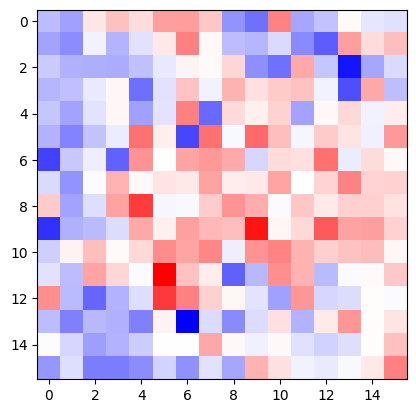

In [ ]:
plt.imshow(latent[1][1].detach().numpy(), cmap="bwr")

In [ ]:
batch["pixels"][0].permute(1,2,0)[:,:,11].detach().numpy()

array([[-0.01246017, -0.02784646, -0.0444915 , ...,  0.09696781,
         0.21106492,  0.11906873],
       [-0.00763035, -0.00441564, -0.01447678, ...,  0.04624269,
         0.13017079,  0.08654074],
       [-0.0275357 , -0.02705069,  0.00513181, ..., -0.01385808,
         0.02237789,  0.0461733 ],
       ...,
       [-0.0451439 ,  0.0447403 ,  0.1230152 , ..., -0.01493489,
        -0.0518337 , -0.08400981],
       [-0.04823124,  0.06080151,  0.08305081, ..., -0.05319439,
        -0.08664446, -0.09089882],
       [-0.07881664, -0.02791659,  0.01140391, ..., -0.05890915,
        -0.0602114 , -0.05528775]], dtype=float32)

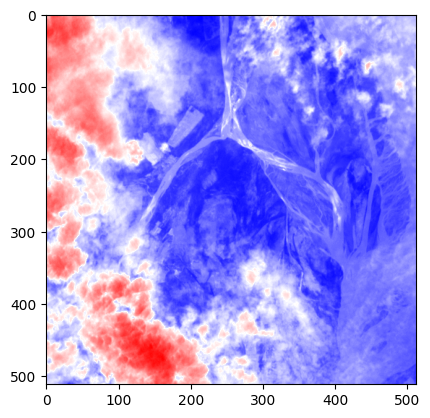

In [ ]:
plt.imshow(batch["pixels"][1].permute(1,2,0)[:,:,2].detach().numpy(), cmap="bwr")

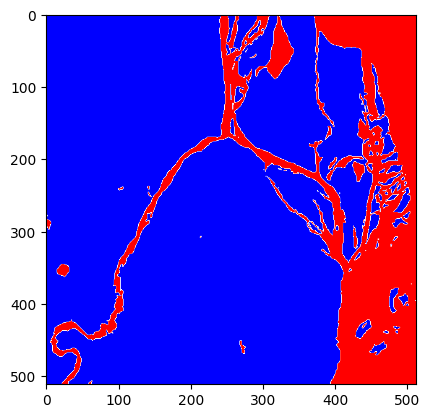

In [ ]:
plt.imshow(batch["labels"][1].permute(1,2,0)[:,:,:].detach().numpy(), cmap="bwr")

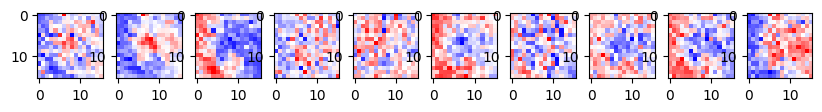

In [ ]:
fig, axs = plt.subplots(1,10,figsize=(10,5))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(latent[1][i+10].detach().numpy(), cmap="bwr")

## Train from scratch

In [ ]:
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange

class UNet_fromscratch(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(128, 512, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(512, out_channels, kernel_size=3, padding=1), # output channels = 2 because classes [0,1]
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x = self.decoder(x1)
        return x


class SegmentationModel_fromscratch(LightningModule):
    def __init__(self, model, datamodule):
        super().__init__()
        self.model = model
        self.datamodule = datamodule


    def training_step(self, batch, batch_idx):
        print(batch["pixels"].shape, batch["labels"].shape)
        x, y = batch["pixels"], batch["labels"]
        prediction = self.model(x)
        y = y.squeeze()
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(prediction, y.to(dtype=torch.long))
        self.log("train_loss", loss)
        print("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["pixels"], batch["labels"]
        prediction = self.model(x)
        y = y.squeeze()
        loss_fn = torch.nn.CrossEntropyLoss()
        val_loss = loss_fn(prediction, y.to(dtype=torch.long))
        print("val_loss", val_loss)
        self.log("val_loss", val_loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)
        return optimizer

    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

dm = ClayDataModule(data_dir=data_dir, batch_size=8)
dm.setup()

model_unet_fromscratch = UNet_fromscratch(13, 2)
model_clay = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval();
segmentation_model_fromscratch = SegmentationModel_fromscratch(model_unet_fromscratch, dm)

trainer_fromscratch = Trainer(max_epochs=3)
trainer_fromscratch.fit(segmentation_model_fromscratch)

In [ ]:
def plot_predictions(model, model_clay, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            #print(batch)
            x_val, y_val = batch["pixels"], batch["labels"]

            prediction = model(x_val)
            act = torch.nn.Softmax(dim=1)
            prediction = act(prediction)
            prediction_values, prediction = torch.max(prediction, dim=1)

            # Convert tensors to NumPy arrays for plotting
            x_val_np = x_val.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            prediction_np = prediction.cpu().numpy()

            # Plot images and masks
            num_samples = min(4, len(x_val))  # Number of samples to visualize
            fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))


            for i in range(num_samples):
                print(np.unique(prediction_np[i]))
                axes[i, 0].imshow(
                    np.transpose(
                        np.stack(
                            (
                                x_val_np[i][2, :, :],
                                x_val_np[i][1, :, :],
                                x_val_np[i][0, :, :],
                            )
                        ),
                        (1, 2, 0),
                    ) #.clip(0, 3000) / 3000 #.clip(0, 6000) / 6000
                )
                axes[i, 1].imshow(
                    np.transpose(y_val_np[i], (1, 2, 0))
                )  # Plot ground truths
                axes[i, 2].imshow(prediction_np[i].squeeze())  # Plot model predictions

            plt.show()

model_clay = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval()

plot_predictions(model_unet_fromscratch, model_clay, dm.val_dataloader())

## Finetune from Clay

In [ ]:
from pytorch_lightning import LightningModule, Trainer
from einops import rearrange

class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(4608, 64, kernel_size=1, padding=0),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ConvTranspose2d(8, 2, kernel_size=3, padding=1),
            torch.nn.Upsample(scale_factor=2), # output channels = 2 because classes [0,1]
        )


    def forward(self,x):
        x = self.decoder(x)
        return x


class SegmentationModel(LightningModule):
    def __init__(self, model, datamodule):
        super().__init__()
        self.model = model
        self.datamodule = datamodule

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        print(batch["pixels"].shape, batch["labels"].shape)
        x, y = batch["pixels"], batch["labels"]
        batch["pixels"] = batch["pixels"].to(model_clay.device)
        batch["timestep"] = batch["timestep"].to(model_clay.device)
        batch["latlon"] = batch["latlon"].to(model_clay.device)
        emb = model_clay.model.encoder(batch)
        embeddings = emb[0]
        embeddings = embeddings[:,:-2,:]
        latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
        latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
        latent = rearrange(latent, "b g h w d -> b (g d) h w")
        prediction = self.model(latent)

        y = y.squeeze()
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(prediction, y.to(dtype=torch.long))
        self.log("train_loss", loss)
        print("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["pixels"], batch["labels"]
        batch["pixels"] = batch["pixels"].to(model_clay.device)
        batch["timestep"] = batch["timestep"].to(model_clay.device)
        batch["latlon"] = batch["latlon"].to(model_clay.device)
        emb = model_clay.model.encoder(batch)
        embeddings = emb[0]
        print(embeddings.shape)
        embeddings = embeddings[:,:-2,:]
        latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
        latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
        latent = rearrange(latent, "b g h w d -> b (g d) h w")

        prediction = self.model(latent)
        y = y.squeeze()
        loss_fn = torch.nn.CrossEntropyLoss()
        val_loss = loss_fn(prediction, y.to(dtype=torch.long)) #torch.nn.functional.cross_entropy(prediction, y) 
        print("val_loss", val_loss)
        self.log("val_loss", val_loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)
        return optimizer

    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

dm = ClayDataModule(data_dir=data_dir, batch_size=8)
dm.setup()

model_unet = UNet(13, 2)
model_clay = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval();
segmentation_model = SegmentationModel(model_unet, dm)

trainer = Trainer(max_epochs=3)
trainer.fit(segmentation_model)

In [ ]:
def plot_predictions(model, model_clay, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            #print(batch)
            x_val, y_val = batch["pixels"], batch["labels"]

            emb = model_clay.model.encoder(batch)
            embeddings = emb[0]
            embeddings = embeddings[:,:-2,:]
            latent = rearrange(embeddings, "b (g l) d  -> b g l d", g=6)
            latent = rearrange(latent, "b g (h w) d -> b g h w d", h=16, w=16)
            latent = rearrange(latent, "b g h w d -> b (g d) h w")
            prediction = model(latent)
            sftmx = torch.nn.Softmax(dim=1)
            prediction = sftmx(prediction)
            prediction_values, prediction = torch.max(prediction, dim=1)

            # Convert tensors to NumPy arrays for plotting
            x_val_np = x_val.cpu().numpy()
            y_val_np = y_val.cpu().numpy()
            prediction_np = prediction.cpu().numpy()
            print("prediction values: ", np.unique(prediction_np))

            # Plot images and masks
            num_samples = min(4, len(x_val))  # Number of samples to visualize
            fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))

            for i in range(num_samples):
                print(np.unique(y_val_np[i]))
                axes[i, 0].imshow(
                    np.transpose(
                        np.stack(
                            (
                                x_val_np[i][2, :, :],
                                x_val_np[i][1, :, :],
                                x_val_np[i][0, :, :],
                            )
                        ),
                        (1, 2, 0),
                    )
                )   # Plot input images
                axes[i, 1].imshow(
                    np.transpose(y_val_np[i], (1, 2, 0))
                )  # Plot ground truths
                axes[i, 2].imshow(prediction_np[i].squeeze())  # Plot model predictions

            plt.show()

model_clay = CLAYModule.load_from_checkpoint("../clay-small-70MT-1100T-10E.ckpt", mask_ratio=0.)
model_clay.eval()

plot_predictions(model_unet, model_clay, dm.val_dataloader())
